# Compre KMER errors 
Bryan R Lajoie, Andrew Altomare

In [1]:
import os
import pandas as pd
import numpy as np
import boto3
from pathlib import Path
from statistics import mean, median
from scipy.interpolate import interp1d

import hashlib

import pprint
pp = pprint.PrettyPrinter(indent=4)

from datetime import date

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import seaborn as sns
from IPython.display import display, HTML

plt.rcParams['hatch.linewidth'] = 0.25

%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.facecolor'] = 'w'

from collections import defaultdict

pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
print(cwd)

/home/bryan/git/AvidityManuscript2023/notebooks


In [2]:
reference = "Homo_sapiens_assembly38"
catalog = "GRCH38_10bp_1000000_random"
catalog_hash = hashlib.md5(",".join(catalog).encode('utf-8')).hexdigest()[0:4]
kmer_length = 3

In [3]:
pdf = False

home_dir = Path.home()
work_dir = os.path.join(home_dir,"AvidityManuscript2023/analysis/kmer_error/")

! mkdir -p $work_dir


In [4]:
workflows = []

kmer_error_tsvs = []
kmer_tsv_path = os.path.abspath(os.path.join(cwd,"..","data","kmer-error",f"kmer-{kmer_length}"))
print(kmer_tsv_path)

for file in os.listdir(kmer_tsv_path):
    if file.endswith(".kmer-error.tsv"):
        kmer_error_tsvs.append(os.path.join(kmer_tsv_path,file))

print("")
print(f"found {len(kmer_error_tsvs)} kmer error tsvs")


for kmer_error_tsv in kmer_error_tsvs:
    
    wflow_id = os.path.basename(kmer_error_tsv).replace(".kmer-error.tsv","")
    
    wflow_arr = wflow_id.split("__")
    
    run_id,lirbary_id,fqd,run_kmer,run_catalog,sample_id,file_type = None,None,None,None,None,None,None
    if len(wflow_arr) == 6:
        run_id,fqd,run_kmer,run_catalog,sample_id,file_type = wflow_arr
    elif len(wflow_arr) == 7:
        run_id,lirbary_id,fqd,run_kmer,run_catalog,sample_id,file_type = wflow_arr
    
    assert run_kmer == f"kmer-{kmer_length}"
    
    print("",run_id,sep="\t")
    assert catalog == run_catalog
    
    instrument="AVITI"
    if "novaseq" in wflow_id:
        instrument="NovaSeq6000"
    if "Lotus" in wflow_id:
        instrument="NextSeq2000"
        
    workflow = {
        "wflow_id": wflow_id,
        "tag": instrument,
        "catalog": run_catalog,
        "sample_id": sample_id,
        "kmer_error": kmer_error_tsv
    }

    workflows.append(workflow)

# sort workflows
sort_order = ["tag"]
workflows = sorted(workflows, key=lambda item: [item.get(t) for t in sort_order], reverse=False)

print("")
print(f"workflows [{len(workflows)}]")
for wflow in workflows:
    print("",wflow["wflow_id"],wflow["tag"],sep="\t")

/home/bryan/git/AvidityManuscript2023/data/kmer-error/kmer-3

found 3 kmer error tsvs
	HG002.novaseq.pcr-free.50x
	NA12878-Lotus-F08
	20220601_PLT-03_BBS-0174-OBPA

workflows [3]
	20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG002__kmer-error	AVITI
	NA12878-Lotus-F08__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG001__kmer-error	NextSeq2000
	HG002.novaseq.pcr-free.50x__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG002__kmer-error	NovaSeq6000


In [5]:
def read_kmer_error(wflow_id, wflow, kmer_error_file):

    print("kmer_error",wflow_id,sep="\t")

    dat = []
    with open(kmer_error_file) as in_fh:
        for i,line in enumerate(in_fh):
            line = line.strip()

            kmer, chrom, num_kmer_observations, kmer_base_all, kmer_base_mismatch, kmer_base_mismatch_rate, kmer_error_rate, kmer_correct, kmer_incorrect, kmer_incorrect_rate = line.split("\t")

            dat.append(
                {
                    "wflow_id": wflow_id,   
                    "provider": "unknown",
                    "tag":  wflow["tag"],
                    "catalog": wflow["catalog"],
                    "kmer": kmer,
                    "chrom": chrom,
                    "num_kmer_observations": int(num_kmer_observations),
                    "kmer_base_all": [int(kba) for kba in kmer_base_all.split(",")],
                    "kmer_base_mismatch": [int(kbm) for kbm in kmer_base_mismatch.split(",")],
                    "kmer_base_mismatch_rate": [float(kbmr) for kbmr in kmer_base_mismatch_rate.split(",")],
                    "kmer_error_rate": float(kmer_error_rate),
                    "kmer_correct": int(kmer_correct),
                    "kmer_incorrect": int(kmer_incorrect),
                    "kmer_incorrect_rate": float(kmer_incorrect_rate),
                }
            )

    if len(dat) == 0:
        return pd.DataFrame()

    df = pd.DataFrame(dat)#.set_index("kmer")

    return df


# process offset-error
kmer_error_df = pd.concat({wflow["wflow_id"]:read_kmer_error(wflow["wflow_id"], wflow, wflow["kmer_error"]) for wflow in workflows}, axis=0)
#with pd.option_context('display.max_rows', None, 'display.max_columns', None, ):
#    display(kmer_error_df)

hue = "tag"

n_kmers = len(set(kmer_error_df["kmer"]))
hue_order = set(kmer_error_df[hue])

kmer_error	20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG002__kmer-error
kmer_error	NA12878-Lotus-F08__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG001__kmer-error
kmer_error	HG002.novaseq.pcr-free.50x__FQD-2x150-35x__kmer-3__GRCH38_10bp_1000000_random__HG002__kmer-error


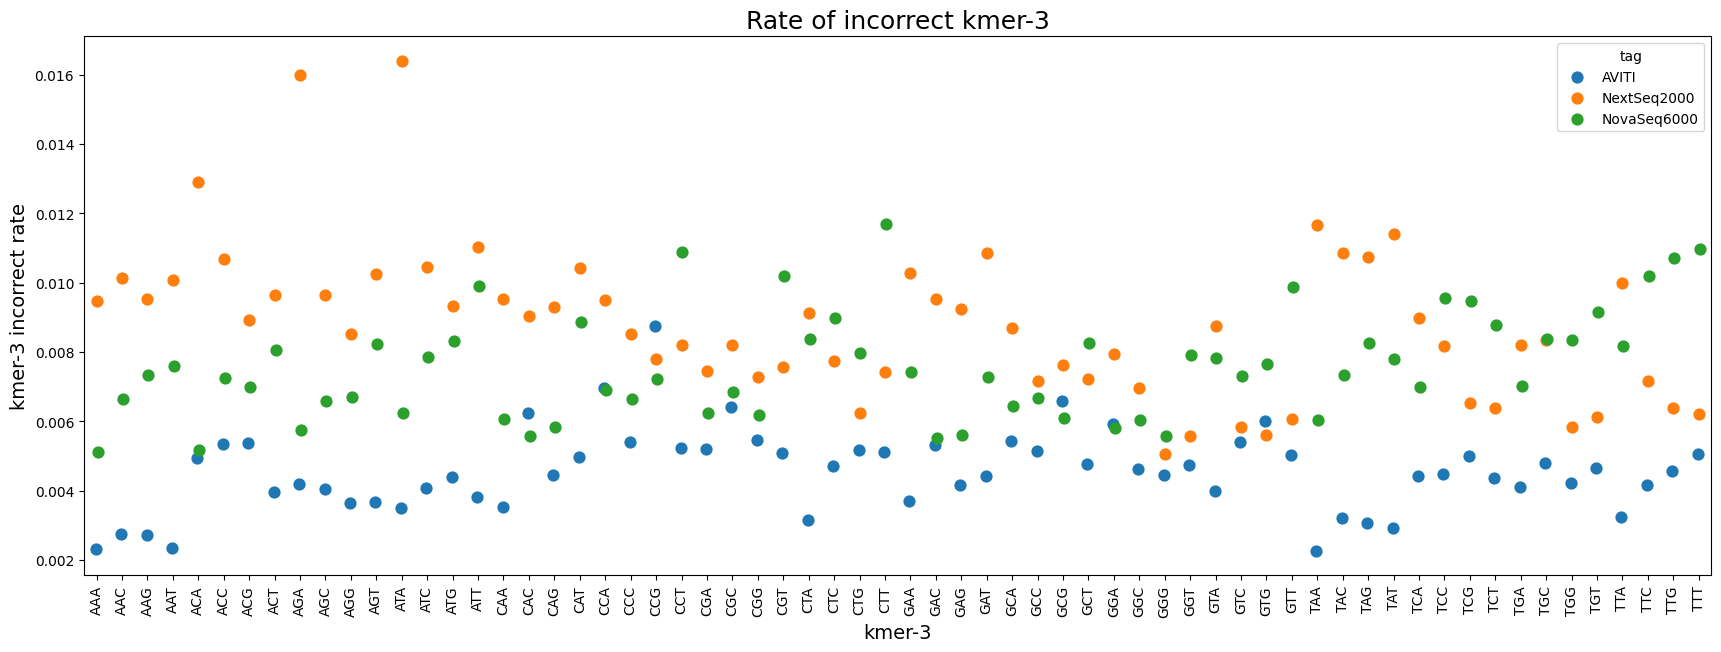

In [7]:
if n_kmers < 10000:
    hue="tag"
    fig, axs = plt.subplots(1,1,figsize=(21,7))

    sns.pointplot(data=kmer_error_df, x="kmer", y="kmer_incorrect_rate", hue=hue, ci=95, join=False, dodge=True)

    plt.xlabel(f"kmer-{kmer_length}", size=14)
    plt.ylabel(f"kmer-{kmer_length} incorrect rate", size=14)
    plt.title(f"Rate of incorrect kmer-{kmer_length}", size=18)

    axs.set_xticklabels(axs.get_xticklabels(), rotation=90, horizontalalignment='center')
    for i,label in enumerate(axs.get_xticklabels()):
         if i % max(1,int(n_kmers/100)) != 0:
            label.set_visible(False)

    plt.savefig(os.path.join(work_dir,f"kmer-error-point__{catalog_hash}__kmer-{kmer_length}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
    if pdf:
        plt.savefig(os.path.join(work_dir,f"kmer-error-point__{catalog_hash}__kmer-{kmer_length}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")



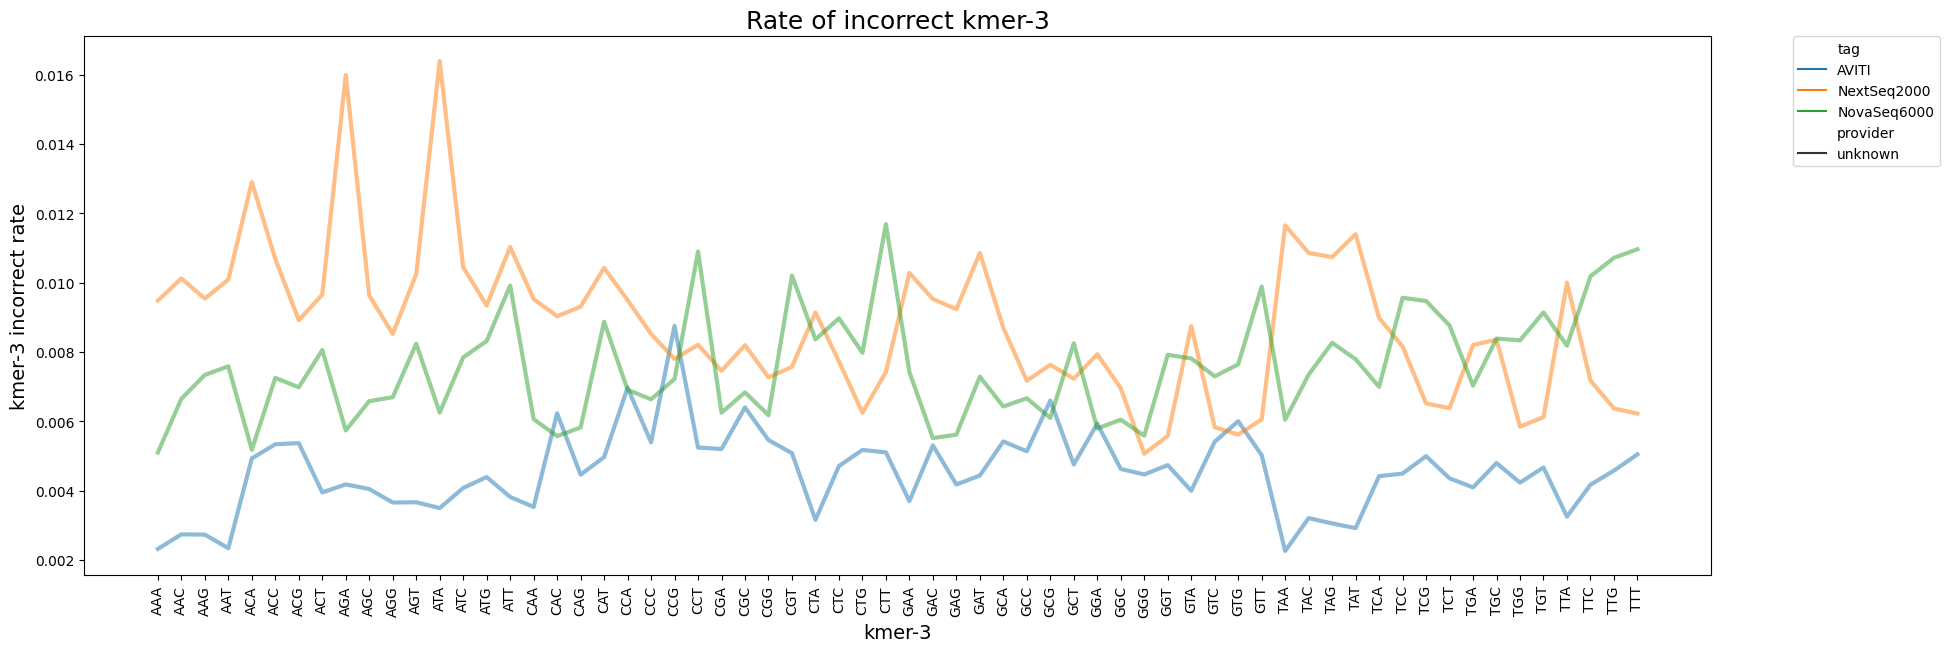

In [8]:
if n_kmers < 10000:
    hue="tag"
    kmer_error_df.to_excel(os.path.join(work_dir,f"kmer-error__{catalog}__{hue}.xlsx"))

    fig, axs = plt.subplots(1,1,figsize=(21,7))

    style="provider"

    sns.lineplot(data=kmer_error_df, x="kmer", y="kmer_incorrect_rate", hue=hue, style=style, linewidth=3, alpha=0.5, markers=False)

    plt.xlabel(f"kmer-{kmer_length}", size=14)
    plt.ylabel(f"kmer-{kmer_length} incorrect rate", size=14)
    plt.title(f"Rate of incorrect kmer-{kmer_length}", size=18)

    axs.set_xticklabels(axs.get_xticklabels(), rotation=90, horizontalalignment='center')
    for i,label in enumerate(axs.get_xticklabels()):
         if i % max(1,int(n_kmers/100)) != 0:
            label.set_visible(False)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.savefig(os.path.join(work_dir,f"kmer-error-line__{catalog_hash}__kmer-{kmer_length}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
    if pdf:
        plt.savefig(os.path.join(work_dir,f"kmer-error-line__{catalog_hash}__kmer-{kmer_length}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")



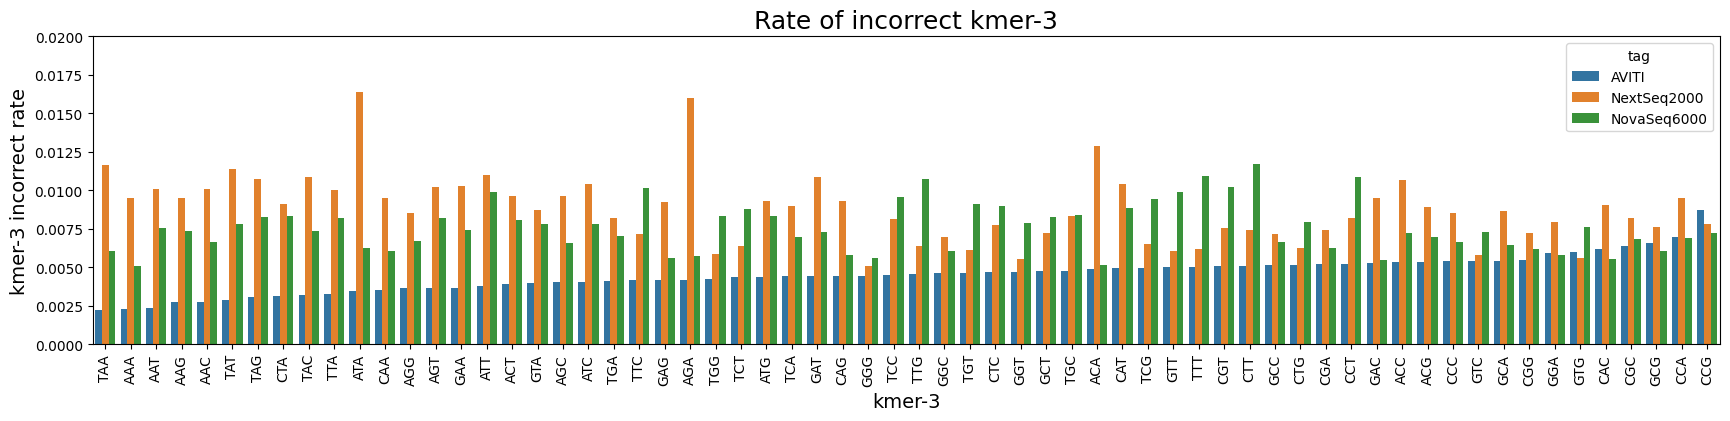

In [10]:
sort_key = "kmer_incorrect_rate"
anchor_wflow_id = f"20220601_PLT-03_BBS-0174-OBPA__FQD-2x150-35x__kmer-{kmer_length}__GRCH38_10bp_1000000_random__HG002__kmer-error"

pdf=False

if n_kmers < 1000:
    hue="tag"
    kmer_error_df.to_excel(os.path.join(work_dir,f"kmer-error__{catalog}__{hue}.xlsx"))

    fig, axs = plt.subplots(1,1,figsize=(21,4))

    sort_df = kmer_error_df[kmer_error_df.wflow_id == anchor_wflow_id]
    order = sort_df.sort_values(by=[sort_key], ascending=True)["kmer"]
    sns.barplot(data=kmer_error_df, x="kmer", y="kmer_incorrect_rate", hue=hue, dodge=True, order=order)

    plt.ylim(0,0.02)

    plt.xlabel(f"kmer-{kmer_length}", size=14)
    plt.ylabel(f"kmer-{kmer_length} incorrect rate", size=14)
    plt.title(f"Rate of incorrect kmer-{kmer_length}", size=18)

    axs.set_xticklabels(axs.get_xticklabels(), rotation=90, horizontalalignment='center')
    for i,label in enumerate(axs.get_xticklabels()):
        if i % max(1,int(n_kmers/100)) != 0:
            label.set_visible(False)

    plt.savefig(os.path.join(work_dir,f"kmer-error-bar__{catalog_hash}__kmer-{kmer_length}__{hue}.png"),dpi=300,format='png',facecolor="w",bbox_inches="tight")
    if pdf:
        plt.savefig(os.path.join(work_dir,f"kmer-error-bar__{catalog_hash}__kmer-{kmer_length}__{hue}.pdf"),dpi=300,format='pdf',facecolor="w",bbox_inches="tight")

pdf=False